# Differential stability 
`Limma` is originally design for micro-array experiments which is mainly doing same task as `DESeq2`.  Comparing to RNA expression analysis, RNA stability may have negetive values; `DESeq2` does not support negetive values but `Limma` does. Therefore, we decided to use `Limma` package instead of `DESeq2` for differential analysis. 

I've learned how to use limma from this [DataCamp course | differential-expression-analysis-with-limma-in-r](https://campus.datacamp.com/courses/differential-expression-analysis-with-limma-in-r/). 
However, I found these links useful while browsing. 
- http://genomicsclass.github.io/book/pages/using_limma.html
- https://www.bioconductor.org/packages/devel/workflows/vignettes/RNAseq123/inst/doc/limmaWorkflow.html

In [ ]:
import os
import subprocess
import glob
import warnings
import pandas as pd
import numpy as np

from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=RRuntimeWarning)

In [1]:
%reload_ext rpy2.ipython

In [4]:
%%R
suppressMessages(suppressWarnings(library(edgeR)))
suppressMessages(suppressWarnings(library(Biobase)))
suppressMessages(suppressWarnings(library(rtracklayer)))
suppressMessages(suppressWarnings(library(tidyverse)))

Read gene annotations into R 

In [5]:
%%R
GTF = '/rumi/shams/genomes/hg38/hg38_ensemble_genes.gtf'

gtf <- rtracklayer::import(GTF)
gene2name <- gtf[gtf$type == "gene"] %>% data.frame %>% column_to_rownames('gene_id') %>% dplyr::select('gene_name')

Make meta table:

In [27]:
%%R
# meta table
treats  <- rep(c(rep('DMSO',2), rep('treated',2)),3)
reps    <- rep(c('rep1','rep2'),6)
hours   <- c(rep('6h',4),rep('72h',4),rep('120h',4))
hours = factor (hours, levels = c("6h", "72h", "120h"))

samples = paste(hours, treats, reps, sep='_')
group = paste(hours, treats, sep='.')

meta <- data.frame(
    time=factor(hours), 
    cond=factor(treats),
    group=factor(group),
    sample_id=samples,
    row.names=samples)
meta$cond <- relevel(meta$cond, ref='DMSO')
meta$group <- relevel(meta$group, ref='6h.DMSO')
meta$time


 [1] 6h   6h   6h   6h   72h  72h  72h  72h  120h 120h 120h 120h
Levels: 6h 72h 120h


#### REMoving Bias from Rna-seq ANalysis of Differential Transcript Stability
[REMBRANDTS](https://github.com/csglab/REMBRANDTS) is a package for analysis of RNA-seq data across multiple samples in order to obtain unbiased estimates of differential mRNA stability. It uses DESeq to obtain estimates of differential pre-mRNA and mature mRNA abundance across samples, and then estimates a gene-specific bias function that is then subtracted from Δexon–Δintron to provide unbiased differential mRNA stability measures.



In [28]:
# Read `REMBRANDTS` results
stbl = pd.read_csv('../REMBRANDTS.txt', sep='\t',index_col='GeneID')

In [30]:
%%R -i stbl
stbl = stbl %>% select(rownames(meta))

# Make annotation dataframe 
ann = data.frame(
    name=gene2name[rownames(stbl),],
    row.names=rownames(stbl)
)

# Create ExpressionSet object
eset <- ExpressionSet(
    assayData = as.matrix(stbl),
    phenoData = AnnotatedDataFrame(meta),
    featureData = AnnotatedDataFrame(ann)
)

In [31]:
%%R 
# Create design matrix
design <- model.matrix(~cond + group, meta)
# Count the number of samples modeled by each coefficient
colSums(design)

      (Intercept)       condtreated    group120h.DMSO group120h.treated 
               12                 6                 2                 2 
  group6h.treated     group72h.DMSO  group72h.treated 
                2                 2                 2 


In [32]:
%%R 
cm = makeContrasts(
    # contrast design: treatment at 120h vs dmso at 120h
    hl60_120h = condtreated + group120h.treated - group120h.DMSO,
#     # contrast design: treatment at 72h vs dmso at 72h
#     hl60_72h = condtreated + group72h.treated - group72h.DMSO,
    # contrast design: treatment at 6h vs dmso at 6h
    hl60_6h = condtreated + group6h.treated,
    levels = design
)

# Fit coefficients 
fit <- lmFit(eset, design)
# Fit contrasts 
fit2 <- contrasts.fit(fit, contrasts = cm)
# Calculate t-statistics 
fit2 <- eBayes(fit2)
# Summarize results 
results <- decideTests(fit2)
print (summary (results))

Coefficients not estimable: group72h.treated 
       hl60_120h hl60_6h
Down          84       0
NotSig      2618    2776
Up            74       0


I don't understand why "Coefficients not estimable: group72h.treated"!

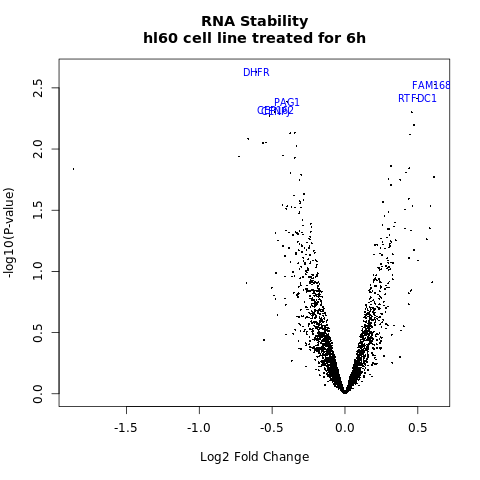

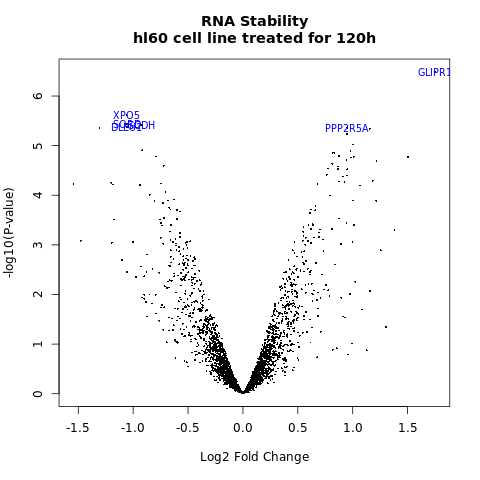

In [33]:
%%R 
volcanoplot(fit2[,'hl60_6h'],highlight = 6, names = fit2$genes[,'name'], main = 'RNA Stability\nhl60 cell line treated for 6h')
volcanoplot(fit2[,'hl60_120h'],highlight = 6, names = fit2$genes[,'name'], main = 'RNA Stability\nhl60 cell line treated for 120h')

Box plot generator for top hits .. 

In [34]:
%%R 
boxplot_top_hit <- function (gene_name){
    gene = (fData(eset) %>% rownames_to_column('row'))$row[fData(eset)$name == gene_name]
    # Create a boxplot of a given gene
    boxplot(exprs(eset)[gene, ] ~ pData(eset)[, "cond"],main = fData(eset)[gene, "name"])
    boxplot(exprs(eset)[gene, ] ~ pData(eset)[, "time"],main = fData(eset)[gene, "name"])
}


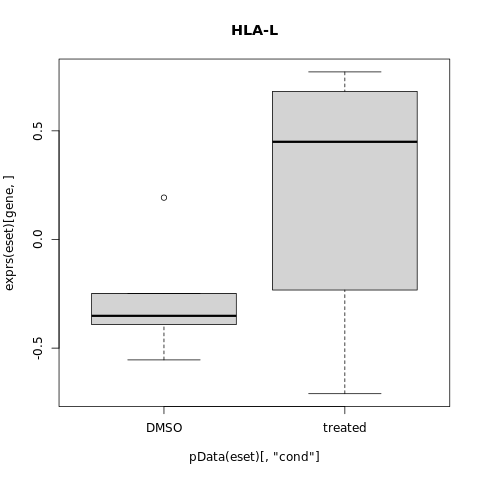

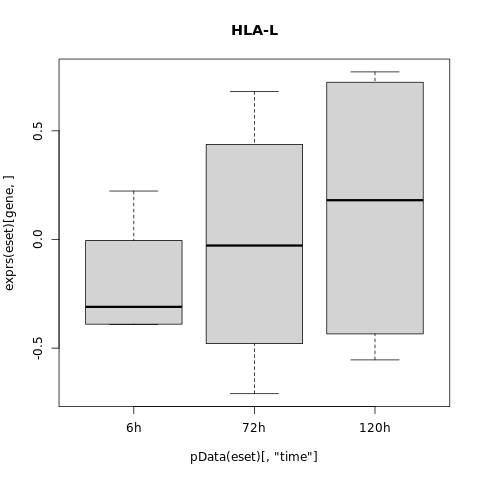

In [35]:
%%R 
boxplot_top_hit('HLA-L')

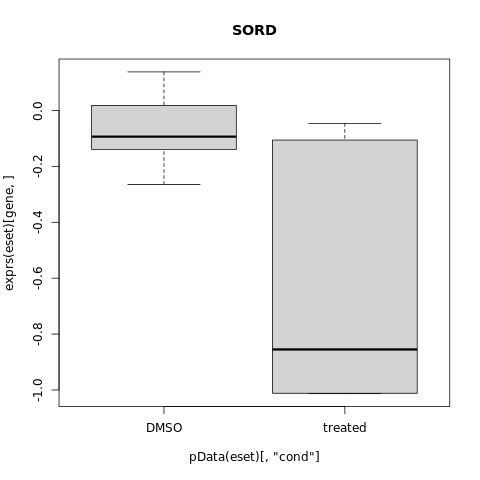

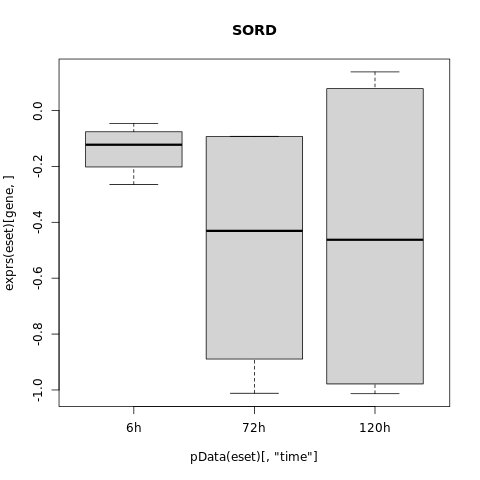

In [36]:
%%R 
boxplot_top_hit('SORD')

## Principal Component Analysis (PCA)
Just like the RNA-seq experssion analysis, sample `72h_treated_rep2` comes up as an outlier. Removing that from the analysis give us a better representation. Therfore, we can see that treated samples at 6h cluster with the non-treated samples which suggest that 6 hours treatment with the drug is not as effective as 72h and 120h. Although, we will check the variant genes in this time-point in the following statistical analysis.


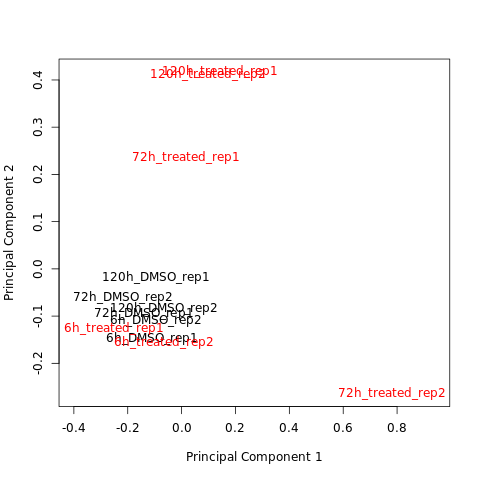

In [37]:
%%R 
# Plot principal components labeled by treatment
col_by_cond=rep(c(rep("black",2), rep("red",2)),3)
plotMDS(eset, labels = pData(eset)[, "sample_id"], col=col_by_cond, gene.selection = "common")

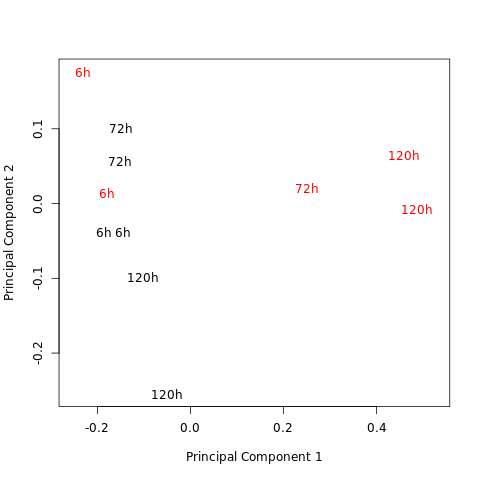

In [38]:
%%R 
# Plot principal components labeled by treatment
filter = !eset@phenoData@data$sample_id == '72h_treated_rep2'
plotMDS(eset[,filter], labels = pData(eset[,filter])[, "time"], col=col_by_cond[filter], gene.selection = "common")

## Normalizing and filtering


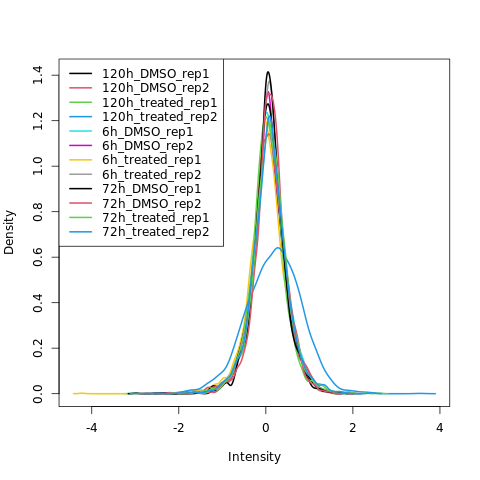

In [42]:
%%R 
# Create new ExpressionSet to store normalized data
eset_norm <- eset
# View the distribution of the raw data
p0 = plotDensities(eset_norm) #, legend = FALSE)

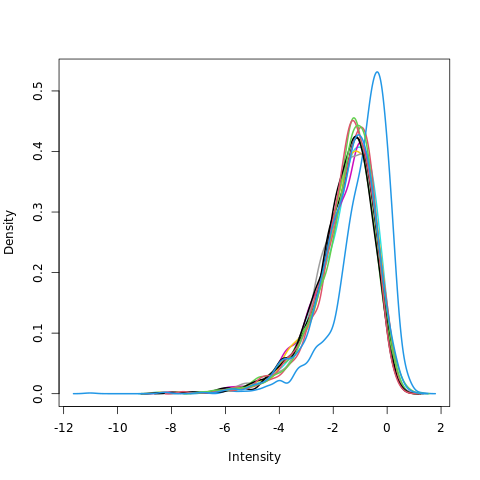

In [43]:
%%R
# Log tranform
exprs(eset_norm) <- log(exprs(eset_norm))
plotDensities(eset_norm, legend = FALSE)

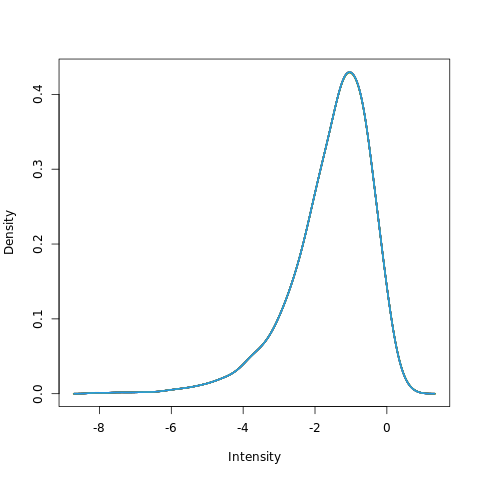

In [44]:
%%R
# Quantile normalize
exprs(eset_norm) <- normalizeBetweenArrays(exprs(eset_norm))
plotDensities(eset_norm, legend = FALSE)

Let's write normalized RNA-Stabilities into a file. 

In [45]:
%%R 
# replace NA with 0 (?!)
ncu <- exprs(eset_norm) %>% replace_na(0)
write.table(ncu,'hl60_stbl_norm_log_quantile.txt', sep="\t", quote=FALSE, col.names=TRUE)

ncu %>% summary

  6h_DMSO_rep1      6h_DMSO_rep2     6h_treated_rep1    6h_treated_rep2  
 Min.   :-8.0913   Min.   :-8.0913   Min.   :-8.09130   Min.   :-8.0913  
 1st Qu.:-1.5050   1st Qu.:-1.5379   1st Qu.:-1.38028   1st Qu.:-1.5719  
 Median :-0.4600   Median :-0.5365   Median :-0.06676   Median :-0.5969  
 Mean   :-0.8956   Mean   :-0.9222   Mean   :-0.80553   Mean   :-0.9478  
 3rd Qu.: 0.0000   3rd Qu.: 0.0000   3rd Qu.: 0.00000   3rd Qu.: 0.0000  
 Max.   : 0.7174   Max.   : 0.7174   Max.   : 0.71743   Max.   : 0.7174  
 72h_DMSO_rep1     72h_DMSO_rep2     72h_treated_rep1  72h_treated_rep2 
 Min.   :-8.0913   Min.   :-8.0913   Min.   :-8.0913   Min.   :-8.0913  
 1st Qu.:-1.4925   1st Qu.:-1.4955   1st Qu.:-1.4465   1st Qu.:-1.5957  
 Median :-0.4294   Median :-0.4363   Median :-0.3052   Median :-0.6348  
 Mean   :-0.8856   Mean   :-0.8878   Mean   :-0.8511   Mean   :-0.9656  
 3rd Qu.: 0.0000   3rd Qu.: 0.0000   3rd Qu.: 0.0000   3rd Qu.: 0.0000  
 Max.   : 0.7174   Max.   : 0.7174   Max.   

what kind of p-value will be the right one to identify differentially expressed genes
https://www.biostars.org/p/18470/

https://support.bioconductor.org/p/7084/

In [21]:
# %%R 
# select_thr <- function (adj){
#     x <- -log10(adj)
#     plot(x, type="l")
#     sigline <- c(.05, .01, .005, .001,.0005, .0001)
#     sigline <- -log10(sigline)
#     sigcolors <- c("red", "blue", "green", "yellow","pink","purple")
#     sapply(1:length(sigline), function(x){abline(h=sigline[x], col=sigcolors[x])})
# }

In [ ]:
# %%R 
# select_thr(stats_120h$adj.P.Val)

In [22]:
# %%R 
# select_thr(stats_6h$adj.P.Val)

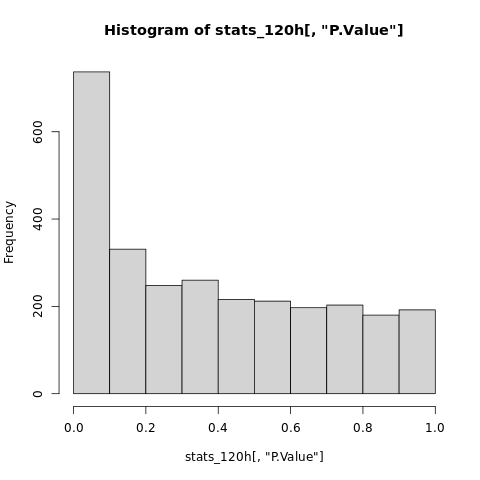

In [46]:
%%R 
# Obtain the summary statistics 
stats_120h <- topTable(fit2, coef = "hl60_120h", adjust.method="fdr", number = nrow(fit2),
                              sort.by = "none")

# Create histograms of the p-values for each contrast
hist(stats_120h[, "P.Value"])

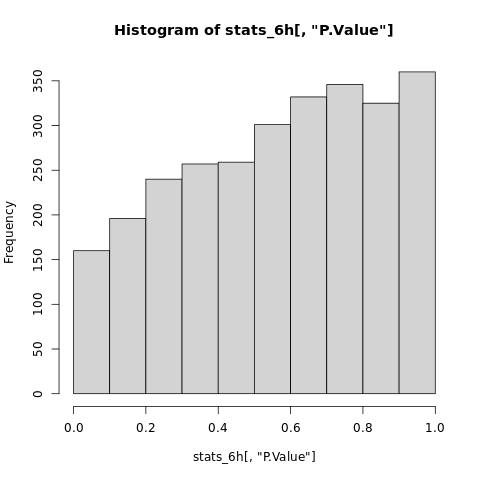

In [47]:
%%R 
# Obtain the summary statistics 
stats_6h <- topTable(fit2, coef = "hl60_6h", number = nrow(fit2),
                              sort.by = "none")

# Create histograms of the p-values for each contrast
hist(stats_6h[, "P.Value"])

# Write result tables into file

Here, I write all results into files which includes log2FC and p.values for contrasts at hour 6 and hour 120, plus gene names and gene ids. 

In [74]:
%%R 
results = data.frame(
    ensembl_id=rownames(fit2$genes),gene_name=fit2$genes$name,
    AveExpr=stats_120h$AveExpr,
    logFC_120h=stats_120h$logFC, P.Value_120h=stats_120h$P.Value, adj.P.Val_120h=stats_120h$adj.P.Val, 
    logFC_6h=stats_6h$logFC, P.Value_6h=stats_6h$P.Value, adj.P.Val_6h=stats_6h$adj.P.Val
)  %>%  remove_rownames  %>% arrange(abs(across(starts_with("logFC"))))

# all results 
write.table(results, 
            'hl60_delta_stbl_table.txt', quote = F, col.names=TRUE, row.names=FALSE,sep ='\t')

## Enrichment analysis

Write iGET friendly tables:

In [75]:
%%R 
write.table(results[,c('ensembl_id','logFC_6h')] , '6h_delta_stbl.txt', 
            quote = F, col.names=FALSE, row.names=FALSE,sep ='\t')
write.table(results[,c('ensembl_id','logFC_120h')] , '120h_delta_stbl.txt', 
            quote = F, col.names=FALSE, row.names=FALSE,sep ='\t')



In [51]:
%%bash
ipage=/rumi/shams/abe/Workflows/my_scripts/ipage_human_ensembl.sh 
nohup ls *delta_stbl.txt | parallel -j18 -k bash $ipage {} &> ipage.out &

In [ ]:
# %%R 
# # Extract the entrez gene IDs
# entrez <- rownames(fit2$genes) 
# # Test for enriched KEGG Pathways
# enrich_kegg <- kegga(fit2, geneid = entrez, species = 'Hs')

# # View the top 20 enriched KEGG pathways
# topKEGG(enrich_kegg)

In [ ]:
%%bash
declare -a Comp=('6h' '120h')



for f in `ls -d /flash/bin/iPAGEv1.0/PAGE_DATA/ANNOTATIONS/human_ensembl*`; do
    base=`basename "$f"`
    echo '<table>' >> README.md
    echo '  <tr>' >> README.md
    echo '  <h2>'$base'<h2>' >> README.md
    for C in "${Comp[@]}"; do
        echo '    <td><img src=plots/'${C}'_PAGE_'${base}'.png style="width:600px">' >> README.md
    done
    echo '  <tr>' >> README.md
    echo '<table>' >> README.md
done

## Clustering 

In [76]:
%%R 
df_sig = results %>% 
    filter (
        logFC_120h > 1 & adj.P.Val_120h < 0.05 
#         P.Value_120h   < 0.001 |
#         adj.P.Val_6h   < 0.05 
#         adj.P.Val_120h < 0.05)
           ) %>% 
    remove_rownames %>% column_to_rownames('ensembl_id') 

df_sig %>% dim

[1] 13  8


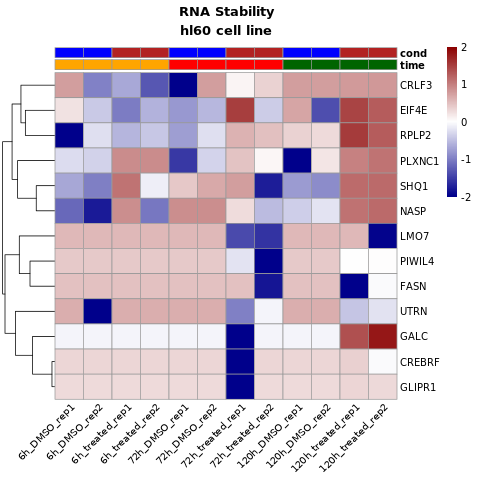

In [77]:
%%R 
library(RColorBrewer)
library(pheatmap)

# Subset normalized counts to significant genes
sig_norm_counts <- ncu[rownames(df_sig), ]
rownames(sig_norm_counts) <- df_sig$gene_name

ann_colors = list(cond = c('DMSO'="darkgreen", 'treated'="firebrick"))



# Choose heatmap color palette
# heat_colors <- brewer.pal(n = 6, name = "YlOrRd")
colors <- c(seq(-2,2,by=0.01)) # ,max(sig_norm_counts))
my_palette <- c("darkblue",colorRampPalette(colors = c("darkblue", "white", "darkred"))
                                                   (n = length(colors)-3), "red")

ann_colors = list(
    cond = c('DMSO'="blue", 'treated'="firebrick"),
    time = c('120h'= "darkgreen", '72h'="red", '6h'="orange")
)

# Plot heatmap
h = pheatmap(sig_norm_counts, 
         cluster_cols = F, 
         main = 'RNA Stability\nhl60 cell line',
         cluster_rows = T, 
         show_rownames = T,
         annotation = select(meta, time, cond), 
         scale = 'row', 
         angle_col= 45,
         annotation_legend=F,
         color = my_palette, 
         breaks = colors,

         annotation_colors = ann_colors)



In [70]:
%%R 
# https://stackoverflow.com/questions/43051525/how-to-draw-pheatmap-plot-to-screen-and-also-save-to-file
pdf('plots/Heatmap_clustering.pdf', width=7, height=7)
grid::grid.newpage()
grid::grid.draw(h$gtable)
dev.off()

png 
  2 


In [86]:
%%R 
 %>% dim

[1] 2478   12


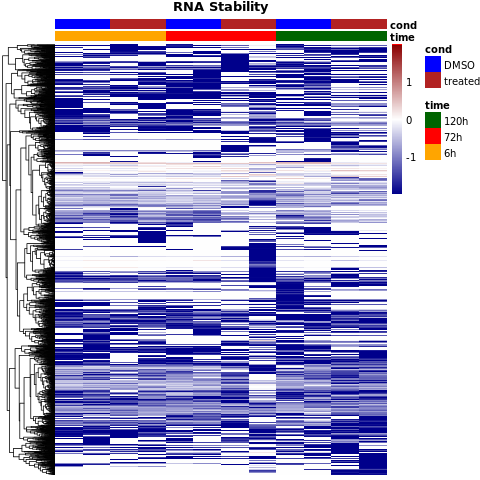

In [91]:
%%R 
# Subset normalized counts to significant genes
sig_norm_counts <- ncu[rowSums(ncu) != 0,]
rownames(sig_norm_counts) = ann[rownames(sig_norm_counts),]

# Plot heatmap
h2 = pheatmap(sig_norm_counts, 
         cluster_cols = F, 
         cluster_rows = T, 
         show_rownames = F,
         show_colnames = F,
         main = 'RNA Stability',
         annotation = select(meta, time, cond), 
#          scale = 'row', 
         color = my_palette, 
         breaks = colors,margin = c(-2,2),
         angle_col= 45,
         legend_breaks = -1:1,
#          annotation_legend=F,
         annotation_colors = ann_colors
            )


In [92]:
%%R 
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS/LAPACK: /rumi/shams/abe/anaconda3/envs/deseq2/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] stats4    parallel  tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] pheatmap_1.0.12      RColorBrewer_1.1-2   forcats_0.5.0       
 [4] stringr_1.4.0        dplyr_1.0.1          purrr_0.3.4         
 [7] readr_1.3.1          tidyr_1.1.1          tibble_3.0.3        
[10] ggplot2_3.3.2        tidyverse_1.3.0      rtracklaye